In [1]:
## Environment

### Main imports

# !pip install --upgrade "numpy==1.20.2"
import os
import numpy as np
import pandas as pd
import torch

### Plots

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from cycler import cycler

plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('font', family='serif')
plt.rc('axes', prop_cycle=cycler(color='bmrcgyk'))
plt.rc('image', cmap='gist_rainbow')  # gist_rainbow
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')
# set_matplotlib_formats('png')

### Also

rs = {'random_state': 0}
rng = np.random.default_rng(seed=0)

In [2]:
def bins_reliability(true_labels, pred_probs, n_bins=10):
    '''
    Args:
        true_labels: np.array (n,) of integers in range(0, n_classes)
        pred_probs: np.array (n, n_classes) of predicted probabilities
        n_bins: int, number of bins
    
    Returns:
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,)
    '''
    confs = pred_probs.max(axis=1)
    is_correct = (true_labels == pred_probs.argmax(axis=1))
    bins = np.linspace(0, 1, n_bins + 1)
    # [0, 0.1), [0.1, 0.2), ..., [0.9, 1.0 + eps)
    bins[-1] = 1 + 1e-10
    # find which bin each sample is assigned to
    bin_inds = np.digitize(confs, bins, right=False) - 1
    # count number of samples in each bin
    total = np.bincount(bin_inds, minlength=n_bins)
    # find mean confidence for each bin
    bin_confs = np.bincount(bin_inds, confs, minlength=n_bins)
    np.divide(bin_confs, total, out=bin_confs, where=total!=0)
    # find accuracy for each bin
    bin_accs = np.bincount(bin_inds, is_correct, minlength=n_bins)
    np.divide(bin_accs, total, out=bin_accs, where=total!=0)
    weights = total / total.sum()
    return bin_confs, bin_accs, weights

In [3]:
def _ECE(bin_confs, bin_accs, weights):
    '''
    Args (returns from bins_reliability):
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,)

    Returns:
        ece: expected calibration error
    '''
    diffs = np.abs(bin_confs - bin_accs)
    ece = np.average(diffs, weights=weights)
    return ece

def _MCE(bin_confs, bin_accs, weights=None):
    '''
    Args (returns from bins_reliability):
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,), unused

    Returns:
        mce: maximum calibration error
    '''
    diffs = np.abs(bin_confs - bin_accs)
    mce = diffs.max()
    return mce

In [96]:
def _hist_plot_adjust():
    pad = 0.00
    plt.xlim(-pad, 1 + pad)
    plt.ylim(-pad, 1 + pad)
    plt.xticks(np.linspace(0, 1, 6))
    plt.yticks(np.linspace(0.2, 1.0, 5))
    plt.gca().set_aspect('equal')
    plt.gca().tick_params(length=0)

def _reliability_plot(bin_confs, bin_accs, weights=None,
                      name='reliability plot',
                      show=True, path=None):
    '''
    Args:
        bin_confs: np.array (n,), mean confidence for each bin
        bin_accs: np.array (n,), accuracy for each bin
        weights: np.array (n,)
        name: str, plot title
        show: bool, if True, plt.show() will be called
        path: str, location to save figure, default is None
    '''
    n_bins = len(bin_confs)
    bins = np.linspace(0, 1, n_bins + 1)
    centers = (bins[:-1] + bins[1:]) / 2
    plt.bar(centers, bin_confs, color=(1, 0, 0, 0.5), edgecolor='black',
            label='bin confidence', width=1/n_bins)
    plt.bar(centers, bin_accs, color=(0, 0, 1, 0.5), edgecolor='black',
            label='bin accuracy', width=1/n_bins)
    if weights is not None:
        plt.bar(centers, weights, color=(0, 1.0, 0.5, 0.8), edgecolor='black',
                label='bin weight', width=0.5/n_bins)
    plt.plot([0, 1], [0, 1], color='silver', linestyle='--')
    plt.xlabel('confidence')
    #  plt.ylabel('accuracy') not only...
    plt.legend()
    plt.title(name)
    _hist_plot_adjust()
    if show:
        plt.show()
    if path is not None:
        plt.savefig(path)

In [97]:
def load_targets(path):
    with open(os.path.join(path), 'r') as fin:
        targets = np.array([int(target) for target in fin.read().split()])
    return targets
    
def load_logits(path):
    logits_dict = {}
    for lname in os.listdir(path):
        logits_dict[lname[:-3]] = torch.load(os.path.join(path, lname)).numpy()
    return logits_dict

## CIFAR-10

In [100]:
lpath = '../input/calibration/logits/cifar10'
true_labels = load_targets(os.path.join(lpath, 'targets.txt'))
logits_dict = load_logits(os.path.join(lpath, 'v1'))

densenet121, accuracy: 94.06%
densenet121, ece: 2.02%


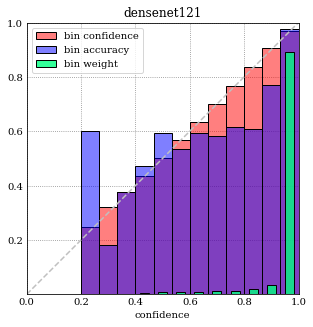

googlenet, accuracy: 92.85%
googlenet, ece: 1.32%


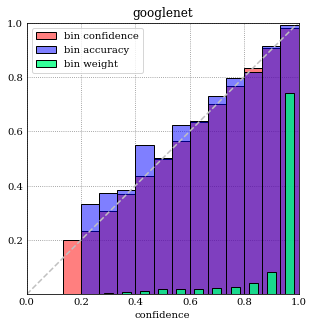

mobilenet_v2, accuracy: 93.91%
mobilenet_v2, ece: 2.52%


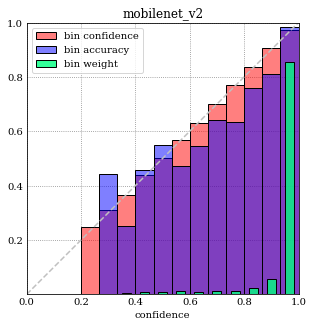

densenet169, accuracy: 94.05%
densenet169, ece: 2.37%


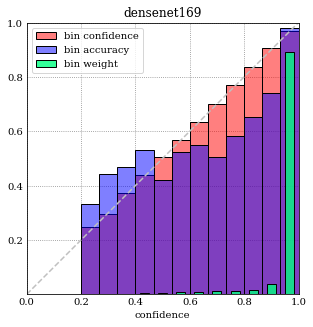

resnet34, accuracy: 93.33%
resnet34, ece: 2.63%


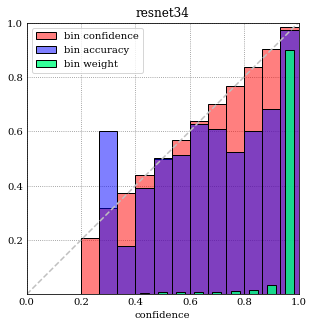

vgg13_bn, accuracy: 94.21%
vgg13_bn, ece: 1.11%


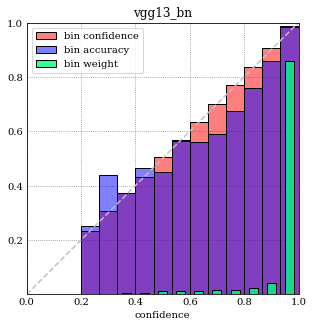

vgg16_bn, accuracy: 94.00%
vgg16_bn, ece: 1.52%


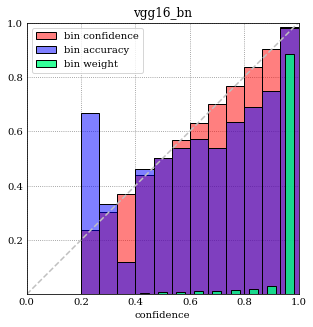

resnet50, accuracy: 93.65%
resnet50, ece: 2.23%


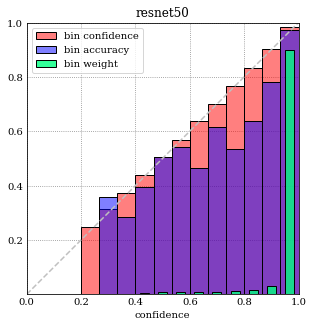

vgg19_bn, accuracy: 93.95%
vgg19_bn, ece: 2.13%


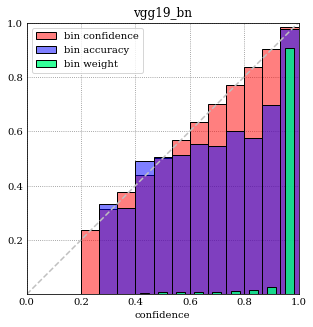

inception_v3, accuracy: 93.74%
inception_v3, ece: 2.07%


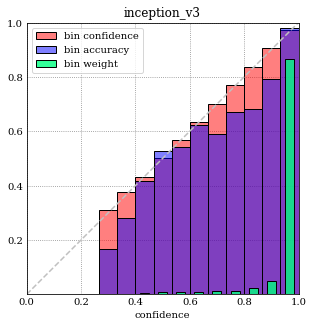

vgg11_bn, accuracy: 92.39%
vgg11_bn, ece: 1.50%


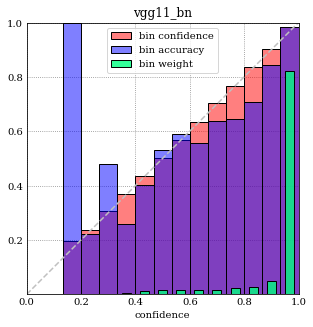

resnet18, accuracy: 93.07%
resnet18, ece: 2.02%


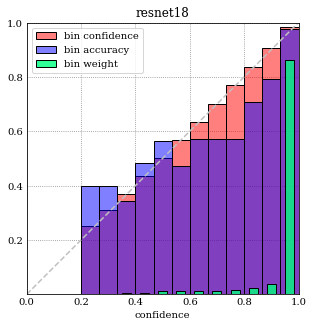

densenet161, accuracy: 94.07%
densenet161, ece: 2.10%


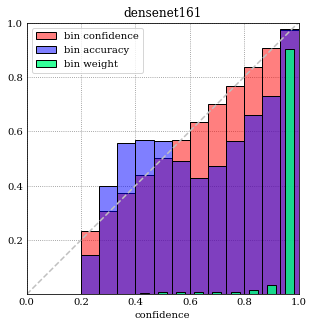

In [101]:
from scipy.special import softmax

for name, logits in logits_dict.items():
    acc = (logits.argmax(axis=1) == true_labels).mean()
    print(f'{name}, accuracy: {acc * 100:.2f}%')
    pred_probs = softmax(logits, axis=1)
    bin_confs, bin_accs, weights = bins_reliability(true_labels, pred_probs, n_bins=15)
    ece = _ECE(bin_confs, bin_accs, weights)
    print(f'{name}, ece: {ece * 100:.2f}%')
    plt.figure(figsize=(5, 5))
    _reliability_plot(bin_confs, bin_accs, weights, name=name, show=False)
    plt.show()

## ImageNet

In [103]:
lpath = '../input/calibration/logits/imagenet'
logits_dict = load_logits(os.path.join(lpath))
true_labels = np.repeat(np.arange(1000), 50)

tf_efficientnet_b8, accuracy: 85.38%
tf_efficientnet_b8, ece: 8.81%


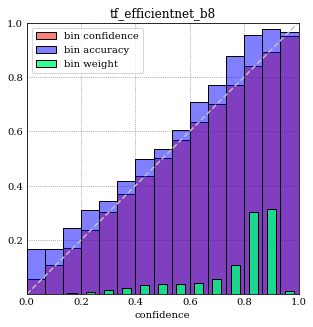

mobilenetv2_120d, accuracy: 77.33%
mobilenetv2_120d, ece: 6.62%


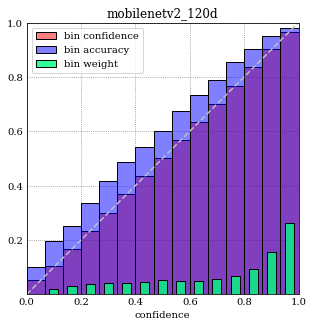

repvgg_b3, accuracy: 80.44%
repvgg_b3, ece: 3.04%


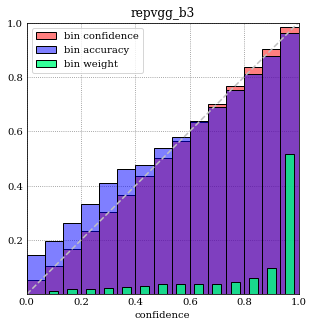

vgg19_bn, accuracy: 74.22%
vgg19_bn, ece: 3.81%


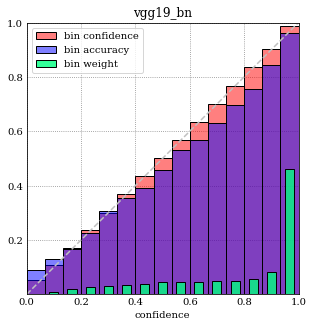

In [104]:
for name, logits in logits_dict.items():
    acc = (logits.argmax(axis=1) == true_labels).mean()
    print(f'{name}, accuracy: {acc * 100:.2f}%')
    pred_probs = softmax(logits, axis=1)
    bin_confs, bin_accs, weights = bins_reliability(true_labels, pred_probs, n_bins=15)
    ece = _ECE(bin_confs, bin_accs, weights)
    print(f'{name}, ece: {ece * 100:.2f}%')
    plt.figure(figsize=(5, 5))
    _reliability_plot(bin_confs, bin_accs, weights, name=name, show=False)
    plt.show()